In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model
from sklearn.model_selection import train_test_split
import os
import IPython.display as display
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import zipfile

# Load and process data

In [ ]:
def columns_to_y(row):
  labels = ["Marker1", "Marker2", "Marker3", "Marker4",
            "ColorLeft", "ColorRight", "GrayScaleRight", "GreyScaleLeft"]#,
            #"CircleTop", "CircleRight", "CircleBottom", "CircleLeft"]

  output = []
  for label in labels:
      for coord in eval(row[label]):
        output.append(float(coord))
  return output

def name_to_path(row, prefix):
  path = prefix + row["photoFullPath"].split("/")[-1].lower()
  return path

def load_image(row):
  img = matplotlib.image.imread(row["path"])
  # if len(img.shape) != 3:
  #  img = np.stack((img,)*3, axis=-1)
  return tf.convert_to_tensor(img, dtype=tf.float32) / 255.0

In [ ]:
frames = []

with zipfile.ZipFile("./drive/My Drive/Colab Notebooks/dataset.zip", 'r') as zip_ref:
  zip_ref.extractall(".")
print(len(os.listdir("dataset")))
for i in range(len(os.listdir("dataset"))):
  data = pd.read_csv("dataset/data{}/labeled_data.csv".format(i), sep="|")
  data["path"] = data.apply(lambda row: name_to_path(row, "./dataset/data{}/source_to_label/".format(i)), axis=1)
  data["y"] = data.apply(lambda row: columns_to_y(row), axis=1)
  frames.append(data[["path", "y"]])

# with zipfile.ZipFile("./drive/My Drive/Colab Notebooks/validation.zip", 'r') as zip_ref:
#     zip_ref.extractall(".")
# validation_data = pd.read_csv("validation/data/data.txt", sep="|", usecols=["photoFullPath1", "LeftTop", "RightTop", "RightLow", "LeftLow"])
# validation_data["path"] = validation_data.apply(lambda row: name_to_path(row, "validation/"), axis=1)
# validation_data["y"] = validation_data.apply(lambda row: columns_to_y(row), axis=1)
# data, _ = train_test_split(validation_data, test_size=0.5)
# frames.append(data[["path", "y"]])

13


In [ ]:
data = pd.concat(frames, ignore_index=True)
data = data.sample(frac=1).reset_index(drop=True)
#validation_data = validation_data.sample(frac=1).reset_index(drop=True)
data, validation_data = train_test_split(data, test_size=0.1)
data = data.sample(frac=1).reset_index(drop=True)
validation_data = validation_data.sample(frac=1).reset_index(drop=True)
print(len(data))
print(len(validation_data))

2677
298


In [ ]:
print(data)
print(validation_data)

                                          path                                                  y
0      ./dataset/data7/source_to_label/459.jpg  [0.1525, 0.8483333333333334, 0.08, 0.226666666...
1       ./dataset/data2/source_to_label/10.jpg  [0.2325, 0.25833333333333336, 0.71, 0.255, 0.7...
2     ./dataset/data10/source_to_label/125.jpg  [0.135, 0.7116666666666667, 0.19, 0.1433333333...
3      ./dataset/data8/source_to_label/150.jpg  [0.2575, 0.8483333333333334, 0.145, 0.31833333...
4      ./dataset/data7/source_to_label/587.jpg  [0.3325, 0.8016666666666666, 0.2675, 0.3366666...
...                                        ...                                                ...
2672   ./dataset/data6/source_to_label/592.jpg  [0.2, 0.86, 0.1625, 0.22333333333333333, 0.922...
2673    ./dataset/data8/source_to_label/28.jpg  [0.1825, 0.77, 0.2125, 0.16333333333333333, 0....
2674  ./dataset/data10/source_to_label/134.jpg  [0.21, 0.8566666666666667, 0.14, 0.32166666666...
2675    ./dataset/da

In [ ]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, batch_size=32, shuffle=True):
        self.batch_size = batch_size
        self.df = df
        self.indices = self.df.index.tolist()
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return len(self.indices) // self.batch_size

    def __getitem__(self, index):
        index = self.index[index * self.batch_size:(index + 1) * self.batch_size]
        batch_indices = [self.indices[k] for k in index]
        
        X, Y = self.__get_data(batch_indices)
        return X, Y

    def on_epoch_end(self):
        self.index = np.arange(len(self.indices))
        if self.shuffle:
            np.random.shuffle(self.index)

    def __get_data(self, batch_indices):
        batch = self.df.iloc[batch_indices,:]
        batch["image"] = batch.apply(lambda row: load_image(row), axis=1)
        X = tf.convert_to_tensor(batch["image"].tolist())
        Y = tf.convert_to_tensor(batch["y"].tolist())
        return X, Y


In [ ]:
dataset = DataGenerator(data)
val_dataset = DataGenerator(validation_data)

# Create Model

**Create model**

In [ ]:
mobile_model = tf.keras.applications.MobileNetV2(include_top=False, input_shape=(224, 224, 3), weights='imagenet')

inputs = tf.keras.Input(shape=(224, 224, 3))
x = mobile_model(inputs)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(.2)(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(.1)(x)
outputs = tf.keras.layers.Dense(16)(x)
detector_model = tf.keras.Model(inputs, outputs)
detector_model.compile(optimizer="Adam", loss="mean_squared_error")

detector_model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
flatten_1 (Flatten)          (None, 62720)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              64226304  
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dropout_3 (Dropout)          (None, 1024)             

**Load model**

In [ ]:
detector_model = tf.keras.models.load_model("./drive/My Drive/Colab Notebooks/mobile2.hdf5")

In [ ]:
detector_model.evaluate(val_dataset)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


9/9 [==============================] - 1s 87ms/step - loss: 2.0116


2.0116214752197266

In [ ]:
detector_model.fit(dataset, validation_data=val_dataset, epochs=50)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
83/83 [==============================] - 25s 298ms/step - loss: 13.7091 - val_loss: 2697.4468
Epoch 2/50
83/83 [==============================] - 24s 294ms/step - loss: 0.0524 - val_loss: 2149.9390
Epoch 3/50
83/83 [==============================] - 24s 292ms/step - loss: 0.0404 - val_loss: 1353.0320
Epoch 4/50
83/83 [==============================] - 24s 293ms/step - loss: 0.0269 - val_loss: 716.1319
Epoch 5/50
83/83 [==============================] - 24s 294ms/step - loss: 0.0203 - val_loss: 338.0490
Epoch 6/50
83/83 [==============================] - 24s 292ms/step - loss: 0.0180 - val_loss: 160.3311
Epoch 7/50
83/83 [==============================] - 24s 292ms/step - loss: 0.0134 - val_loss: 78.4787
Epoch 8/50
83/83 [==============================] - 24s 288ms/step - loss: 0.0116 - val_loss: 31.9747
Epoch 9/50
83/83 [==============================] - 24s 291ms/step - loss: 0.0091 - val_loss: 15.3110
Epoch 10/50
83/83 [==============================] - 24s 293ms/step - lo

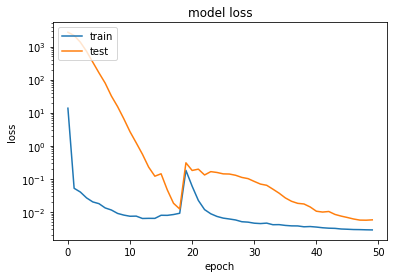

In [ ]:
# summarize history for loss
plt.plot(detector_model.history.history['loss'])
plt.plot(detector_model.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.yscale("log")
plt.show()

In [ ]:
detector_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
flatten (Flatten)            (None, 62720)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              64226304  
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)             

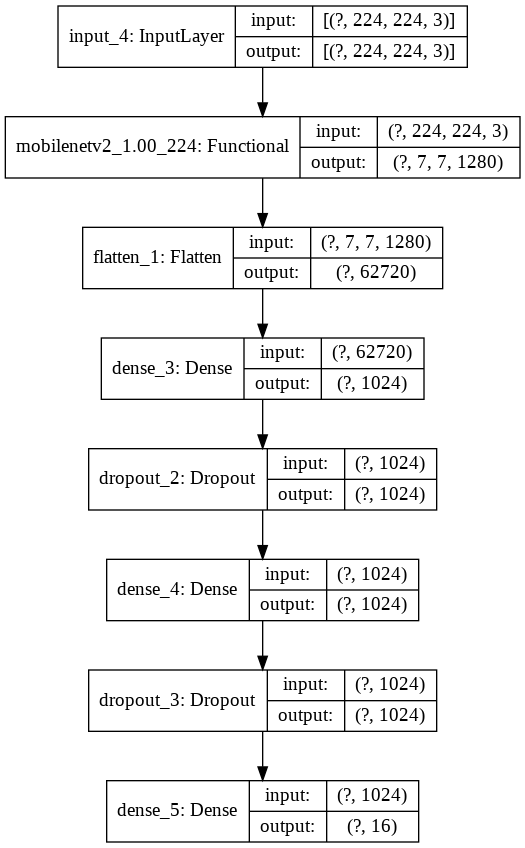

In [ ]:
tf.keras.utils.plot_model(detector_model, show_shapes=True)


In [ ]:
detector_model.save("./drive/My Drive/Colab Notebooks/detector2.hdf5")  

tf.Tensor(
[[0.23090222 0.23661433 0.7649764  0.25149328 0.77733904 0.85247594
  0.23195317 0.8718678  0.17856337 0.35359293 0.8008607  0.35587204
  0.8177767  0.7397656  0.21942624 0.7554627 ]], shape=(1, 16), dtype=float32)
tf.Tensor(
[[ 51.7221    53.00161  171.3547    56.334496 174.12395  190.9546
   51.95751  195.29839   39.998196  79.20482  179.39279   79.71533
  183.18198  165.70749   49.151478 169.22365 ]], shape=(1, 16), dtype=float32)


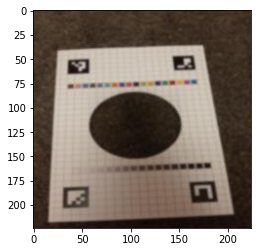

In [ ]:
img = matplotlib.image.imread("./dataset/data1/source_to_label/40.jpg")
input = tf.convert_to_tensor([img], dtype=tf.float32) / 255.0
output = detector_model(tf.convert_to_tensor(input))
plt.imshow(img)
print(output)
print(output * 224)

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(detector_model)
tflite_model = converter.convert()

# Save the model.
with open('./drive/My Drive/Colab Notebooks/detector2.tflite', 'wb') as f:
  f.write(tflite_model)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /tmp/tmpl48_yug1/assets


# Tego niżej nie używamy

In [ ]:
opt = tf.optimizers.Adam()

@tf.function
def train_step(image, y):
  with tf.GradientTape() as tape:
    output = detector_model(image)
    loss = tf.math.reduce_mean(tf.math.squared_difference(y, output))
  grad = tape.gradient(loss, detector_model.trainable_weights)
  opt.apply_gradients(zip(grad, detector_model.trainable_weights))
  return loss

epochs = 40
steps_per_epoch = len(dataset)
display.display("loss = {}".format(0), display_id=44484848484)
for n in range(epochs):
  step = 0
  total_loss = 0
  for m in range(steps_per_epoch):
    step += 1 
    image, y = dataset[m]
    loss = train_step(image, y)
    total_loss += loss
    print(".", end='')
    display.update_display("loss = {}".format(total_loss/step), display_id=44484848484)
  
  detector_model.save("./drive/My Drive/Colab Notebooks/model1.hdf5")
  display.clear_output(wait=True)
  display.display("epoch {}/{}".format(n, epochs))
